# 1. Instalasi Keperluan
Walau akan membangun model ANN dari awal murni menggunakan *Python*, sistem tetap memerlukan beberapa *library* untuk memanipulasi data, menampilkan visual, dan ekstraksi fitur.

In [13]:
%pip install numpy pandas pillow matplotlib scikit-image scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.


# 2. Persiapan Lingkungan
Semua modul diimpor terlebih dahulu, memisahkan library yang hanya untuk pemrosesan gambar dan data, seperti yang telah disebutkan seluruh pembangunan ANN akan diimplementasikan manual.

In [1]:
import os                           # navigasi file/folder  
import random, math                 # angka acak & operasi matematika  
import numpy as np                  # array untuk GLCM & data
import pandas as pd                 # menampilkan data  
import matplotlib.pyplot as plt     # plotting & visualisasi  
from PIL import Image               # read/resize gambar 
from collections import Counter
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from skimage import exposure
from skimage.feature import graycomatrix, graycoprops                   # ekstraksi fitur  
from sklearn.model_selection import train_test_split                    # split data stratified 
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay     # analisa performa

# 3. Memuat dan Menyiapkan Data
Memang dataset sudah berupa gambar grayscale dan ukuran yang sama, namun untuk mencegah adanya kesalahan atau *error* dalam eksperimen, maka sistem akan tetap menjalankan proses ini.

In [2]:
# random.seed(42)
# np.random.seed(42)

data_dir = 'fer2013'  
# Struktur: fer2013/<kategori>/*.jpg
categories = sorted(os.listdir(data_dir))

images, labels = [], []
for idx, cat in enumerate(categories):
    cat_dir = os.path.join(data_dir, cat)
    for fname in os.listdir(cat_dir):
        if fname.lower().endswith('.jpg'):
            img = Image.open(os.path.join(cat_dir, fname)).convert('L')
            img = img.resize((48,48))                   # pastikan 48×48
            images.append(np.array(img, dtype=np.uint8))
            labels.append(idx)

X = np.stack(images)  # shape (N,48,48)
y = np.array(labels)  # shape (N,)
# Tampilkan distribusi awal
print("Distribusi awal per kategori:")
for i,cat in enumerate(categories):
    print(f"  {cat}: {(y==i).sum()} sampel")

Distribusi awal per kategori:
  angry: 4953 sampel
  fear: 5121 sampel
  happy: 8989 sampel
  neutral: 6198 sampel
  sad: 6077 sampel
  surprise: 4002 sampel


# 4. Downsampling (Balancing)
Untuk mencegah kategori mayoritas mendominasi proses training, maka dari itu sistem akan mengambil jumlah kategori terkecil yang kemudian menjadi acuan untuk memilih gambar tiap kategori secara acak.

In [3]:
# cari jumlah sampel terkecil antar kategori
min_count = min((y==i).sum() for i in range(len(categories)))

balanced_idx = []
for i in range(len(categories)):
    idxs = np.where(y==i)[0]
    # memilih acak tanpa pengulangan sebanyak min_count
    balanced_idx.extend(np.random.choice(idxs, min_count, replace=False))

# Shuffle index
random.shuffle(balanced_idx)

X_bal = X[balanced_idx]
y_bal = y[balanced_idx]

# tampilkan distribusi setelah balancing
print("\nDistribusi setelah downsampling:")
for idx, cat in enumerate(categories):
    print(f"  {cat}: {(y_bal==idx).sum()} sampel")


Distribusi setelah downsampling:
  angry: 4002 sampel
  fear: 4002 sampel
  happy: 4002 sampel
  neutral: 4002 sampel
  sad: 4002 sampel
  surprise: 4002 sampel


# 5. Pra-Pemrosesan Data
Setelah melalui proses sebelumnya, data yang sudah seimbang kini bisa dinormalisasikan dan dibagi secara acak dengan rasio 80:20 masing-masing untuk data training dan data testing.

In [4]:
# normalisasi ke rentang [0,1] agar gradien memiliki skala seragam
X_bal = X_bal.astype('float32') / 255.0

# split data stratified (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# tampilkan distribusi data training dan testing
print("\nDistribusi Train/Test (80:20):")
for name, arr in zip(['Train','Test'], [y_train, y_test]):
    print(f"{name}:")
    for idx, cat in enumerate(categories):
        print(f"  {cat}: {(arr==idx).sum()} sampel")


Distribusi Train/Test (80:20):
Train:
  angry: 3202 sampel
  fear: 3202 sampel
  happy: 3201 sampel
  neutral: 3201 sampel
  sad: 3201 sampel
  surprise: 3202 sampel
Test:
  angry: 800 sampel
  fear: 800 sampel
  happy: 801 sampel
  neutral: 801 sampel
  sad: 801 sampel
  surprise: 800 sampel


# 6. Visualisasi Data
Berikut ini merupakan beberapa contoh data gambar wajah yang telah melalui beberapa proses sebelumnya. Visualisasi ini hanya untuk membantu memahami ragam ekspresi, pencahayaan, dan pose yang harus dikenali model.

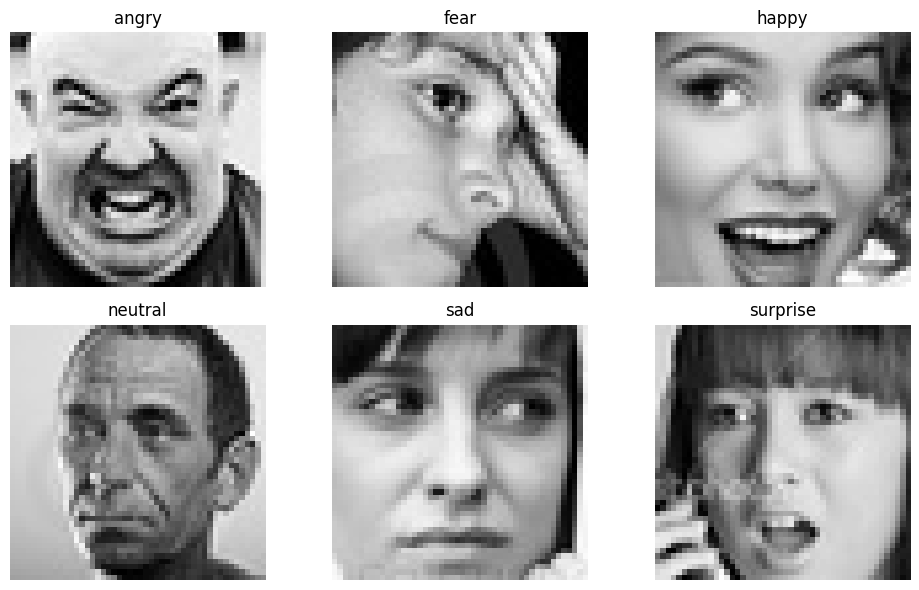

In [5]:
plt.figure(figsize=(10,6))
for idx, cat in enumerate(categories):
    # ambil 1 contoh secara acak dari tiap kategori
    sample = X_train[y_train==idx][np.random.randint((y_train==idx).sum())]
    plt.subplot(2,3,idx+1)
    plt.imshow(sample, cmap='gray')
    plt.title(cat)
    plt.axis('off')
plt.tight_layout(); plt.show()

# 7. Ekstraksi Fitur GLCM
GLCM mampu menangkap tekstur lokal wajah yang penting untuk membedakan ekspresi wajah. Fitur yang dimaksud adalah *contrast, dissimilarity, homogeneity, ASM, energy,* dan *correlation.*


Dimensi fitur: (19209, 6)

Data train:
 label  contrast  dissimilarity  homogeneity       ASM    energy  correlation
     0  0.537699       0.466778    -0.137657 -0.035256  0.167666    -0.406050
     1  1.189328       1.308242    -0.604698 -0.071981 -0.265255    -2.590514
     2  0.481358       1.105566    -0.841445 -0.077092 -0.353639    -0.187616
     3 -0.465627      -0.269756    -0.119649 -0.071627 -0.259619     0.623987
     4 -0.234789      -0.260968    -0.136974 -0.069368 -0.224755    -0.644417
     5  1.184194       1.052512     0.049421 -0.035450  0.165860     0.157763


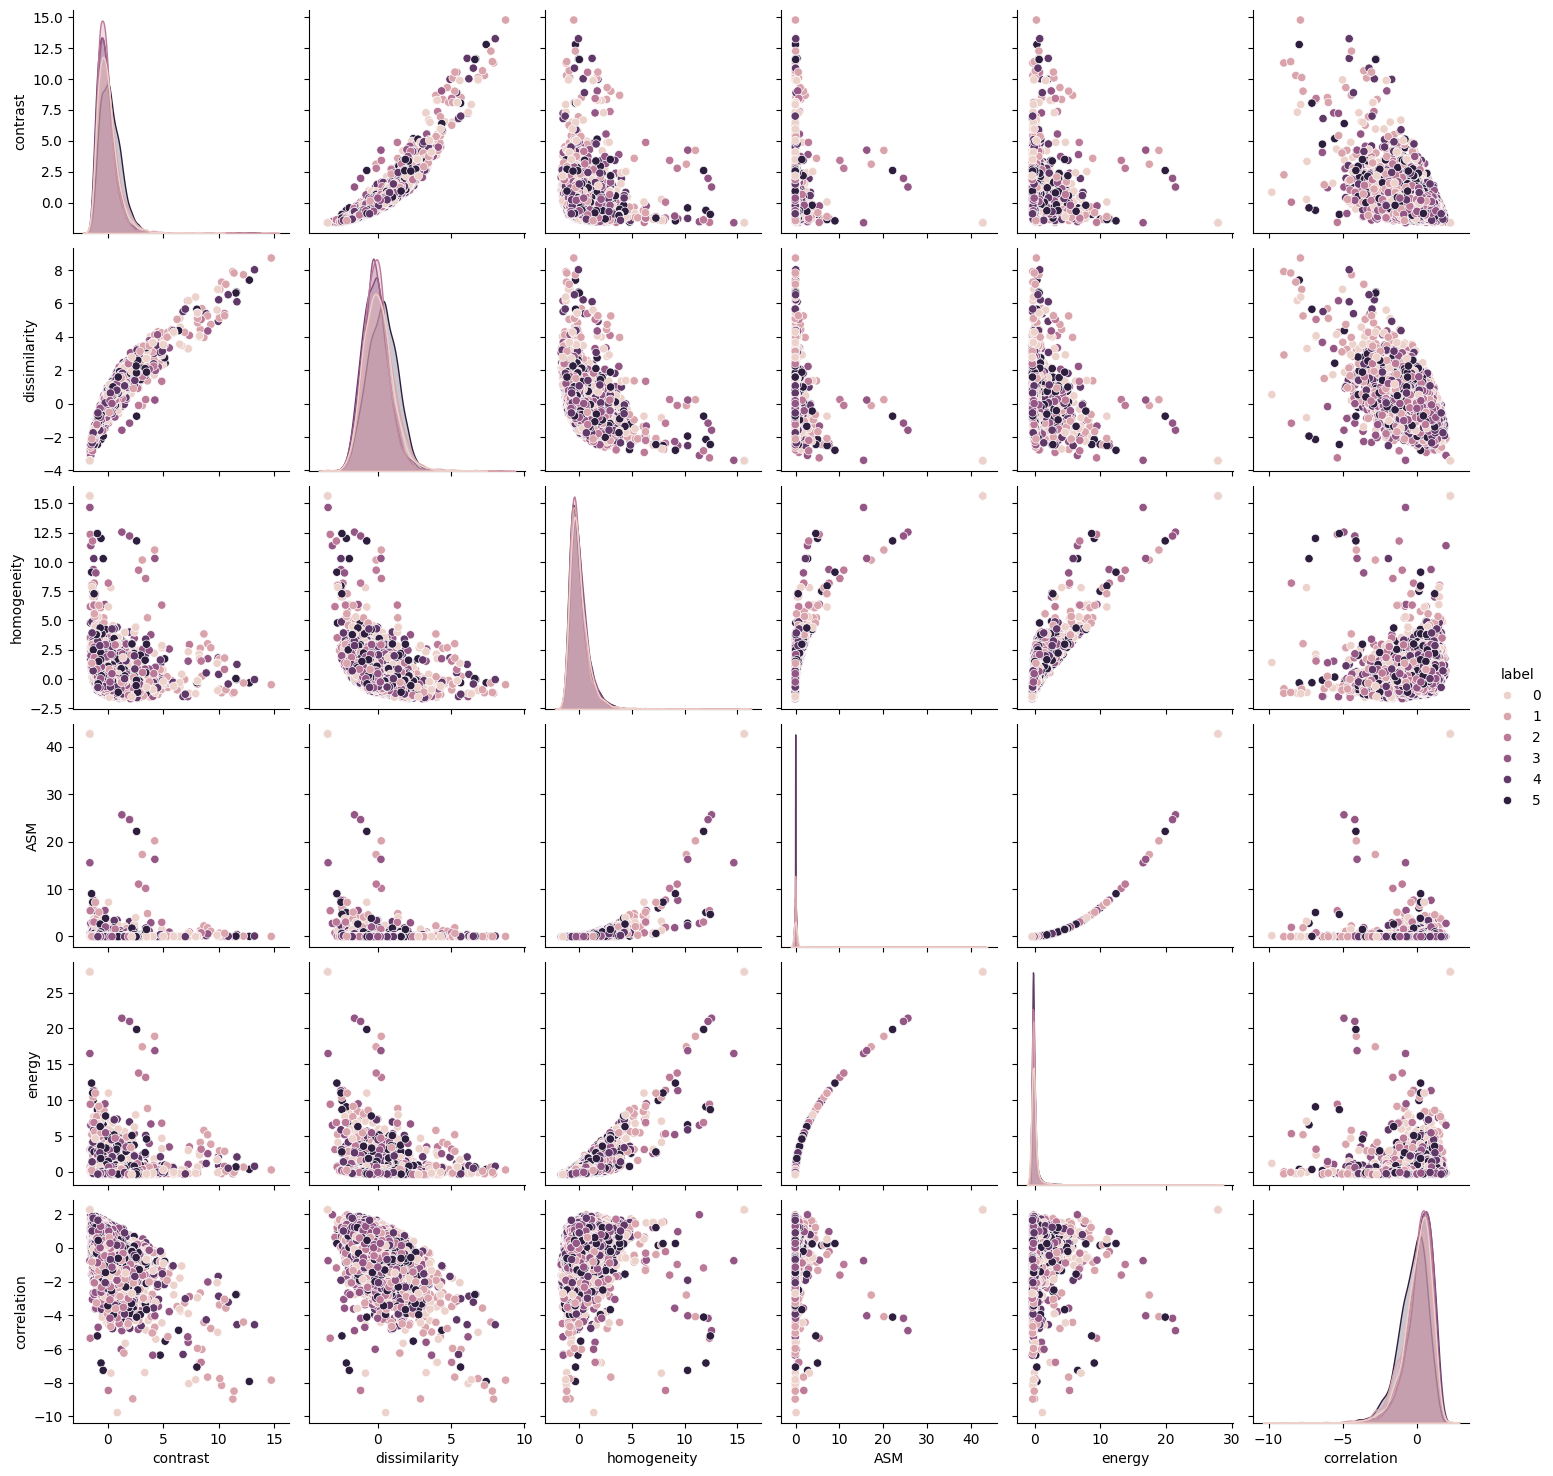

In [6]:
# parameter sederhana
distances = [1]
angles    = [0]
props     = ['contrast','dissimilarity','homogeneity','ASM','energy','correlation']

def extract_glcm_features(img):
    # img shape (48,48) float [0,1]
    u8 = (img*255).astype(np.uint8)
    glcm = graycomatrix(u8, distances, angles, levels=256, symmetric=True, normed=True)
    feats = []
    for prop in props:
        prop_vals = graycoprops(glcm, prop)
        feats.append(prop_vals.mean())  # rata-rata semua kombinasi jarak/sudut
    return feats

# terapkan
feat_train = np.array([extract_glcm_features(img) for img in X_train])
feat_test  = np.array([extract_glcm_features(img) for img in X_test])
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)
feat_test = scaler.transform(feat_test)

print("\nDimensi fitur:", feat_train.shape)  # (N,6)

# 1) Buat DataFrame fitur + label
df_train = pd.DataFrame(feat_train, columns=props)
df_train['label'] = y_train

# 2) Ambil satu contoh per label (0–5)
#    groupby.first() akan mengambil baris pertama setiap grup label
df_one_per_label = df_train.groupby('label', sort=True).first().reset_index()

# 3) Atur ulang kolom ke urutan: label, lalu fitur
cols = ['label'] + props
df_one_per_label = df_one_per_label[cols]

# 4) Tampilkan tanpa nomor baris
print(f"\nData train:")
print(df_one_per_label.to_string(index=False))

df = pd.DataFrame(feat_train, columns=props)
df['label'] = y_train
sns.pairplot(df, hue='label', diag_kind='kde')
plt.show()

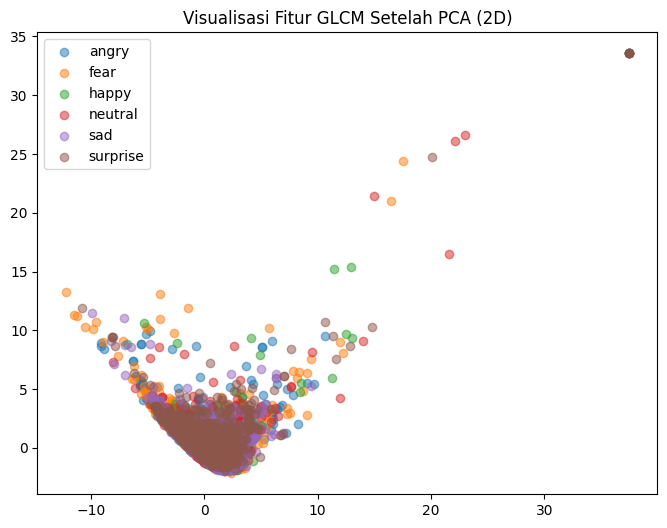

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
feat_2d = pca.fit_transform(feat_train)

plt.figure(figsize=(8,6))
for label in np.unique(y_train):
    plt.scatter(
        feat_2d[np.array(y_train)==label, 0],
        feat_2d[np.array(y_train)==label, 1],
        label=categories[label],
        alpha=0.5
    )
plt.legend()
plt.title("Visualisasi Fitur GLCM Setelah PCA (2D)")
plt.show()

# 8. Pembuatan Model ANN
Tanpa modul Keras atau TensorFlow, sistem harus bisa mengimplementasikan *input layer, hidden layer, output layer, weights* dan *biases,* serta *activation functions* dengan *Python* murni.

In [8]:
input_dim  = feat_train.shape[1]  # 6
hidden_dim = 16
output_dim = len(categories)      # 6

# init bobot & bias
def init_mat(r,c):
    limit = math.sqrt(6/(r+c))
    return [[random.uniform(-limit, limit) for _ in range(c)] for _ in range(r)]

# activations
def tanh(x):
    return math.tanh(x)
def tanh_deriv(x):
    t = math.tanh(x)
    return 1 - t*t

def softmax(z):
    m = max(z)
    exps = [math.exp(v-m) for v in z]
    s = sum(exps)
    return [e/s for e in exps]

def forward(x,W1,b1,W2,b2):
    z1 = [sum(W1[i][j]*x[j] for j in range(input_dim))+b1[i] for i in range(hidden_dim)]
    a1 = [tanh(v) for v in z1]
    z2 = [sum(W2[k][i]*a1[i] for i in range(hidden_dim))+b2[k] for k in range(output_dim)]
    a2 = softmax(z2)
    return z1,a1,z2,a2

def backprop(x,y,z1,a1,z2,a2,W1,b1,W2,b2,lr):
    delta2 = [a2[k] - (1 if k==y else 0) for k in range(output_dim)]
    for k in range(output_dim):
        for i in range(hidden_dim):
            W2[k][i] -= lr*delta2[k]*a1[i]
        b2[k] -= lr*delta2[k]

    delta1 = [sum(delta2[k]*W2[k][i] for k in range(output_dim)) * tanh_deriv(z1[i]) for i in range(hidden_dim)]
    for i in range(hidden_dim):
        for j in range(input_dim):
            W1[i][j] -= lr*delta1[i]*x[j]
        b1[i] -= lr*delta1[i]

def predict(x, W1, b1, W2, b2):
    _,_,_,a2 = forward(x,W1,b1,W2,b2)
    return a2.index(max(a2))

# 9. Hyperparameter Tuning
Dalam tahap ini sistem akan melakukan *manual grid search* untuk mencari model terbaik. Metode ini sendiri berupa format pencarian *hyperparameter* di kotak *grid* dengan iterasi eksplisit.

In [9]:
best_acc, best_cfg = 0,None
for lr in [0.1, 0.01, 0.001]:
    for hd in [8,16,32]:
        # reset
        hidden_dim = hd
        W1 = init_mat(hd,input_dim); b1=[0]*hd
        W2 = init_mat(output_dim,hd); b2=[0]*output_dim
        # train cepat
        for ep in range(10):
            for x,y in zip(feat_train, y_train):
                z1,a1,z2,a2 = forward(x,W1,b1,W2,b2)
                backprop(x, y, z1, a1, z2, a2, W1, b1, W2, b2, lr)
        # eval
        acc = sum(predict(x, W1, b1, W2, b2)==y for x,y in zip(feat_test, y_test))/len(y_test)
        if acc>best_acc:
            best_acc, best_cfg = acc,(lr,hd)
    print(f"Current config: lr={best_cfg[0]}, hidden={best_cfg[1]} → acc={best_acc:.3f}")
print(f"\nBest config: lr={best_cfg[0]}, hidden={best_cfg[1]} → acc={best_acc:.3f}")

Current config: lr=0.1, hidden=8 → acc=0.170
Current config: lr=0.01, hidden=8 → acc=0.222
Current config: lr=0.001, hidden=16 → acc=0.230

Best config: lr=0.001, hidden=16 → acc=0.230


# 10. Evaluasi dan Kesimpulan
Menyelesaikan seluruh proses sebelumnya, akan dicari model terbaik yang telah dibangun dengan melakukan evaluasi dari sisi performa melalui ukuran *accuracy, precision, recall,* dan *f-1 score.*

Counter({3: 1696, 5: 1663, 2: 1041, 4: 288, 1: 79, 0: 36})

Classification Report:
              precision    recall  f1-score   support

       angry       0.28      0.01      0.02       800
        fear       0.27      0.03      0.05       800
       happy       0.21      0.28      0.24       801
     neutral       0.22      0.47      0.30       801
         sad       0.22      0.08      0.12       801
    surprise       0.27      0.57      0.37       800

    accuracy                           0.24      4803
   macro avg       0.25      0.24      0.18      4803
weighted avg       0.25      0.24      0.18      4803



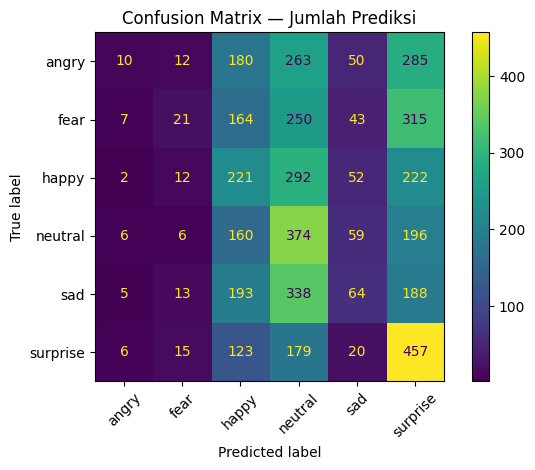

In [10]:
# Gunakan best_cfg, latih penuh
lr = best_cfg[0]
hd = best_cfg[1]
hidden_dim = hd
W1 = init_mat(hd,input_dim); b1=[0]*hd
W2 = init_mat(output_dim,hd); b2=[0]*output_dim

for ep in range(50):
    for x,y in zip(feat_train, y_train):
        z1,a1,z2,a2 = forward(x,W1,b1,W2,b2)
        backprop(x,y,z1,a1,z2,a2,W1,b1,W2,b2,lr)

# Prediksi & laporan
y_pred = [predict(x, W1, b1, W2, b2) for x in feat_test]
print(Counter(y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=categories))
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred,
    display_labels=categories,
)
plt.title("Confusion Matrix — Jumlah Prediksi")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 11. Simpan Model

In [11]:
import pickle

model = {
    "W1": W1,
    "b1": b1,
    "W2": W2,
    "b2": b2,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "output_dim": output_dim,
    "categories": categories
}

with open("glcm_ann_model.pkl", "wb") as f:
    pickle.dump(model, f)

# 12. Demo

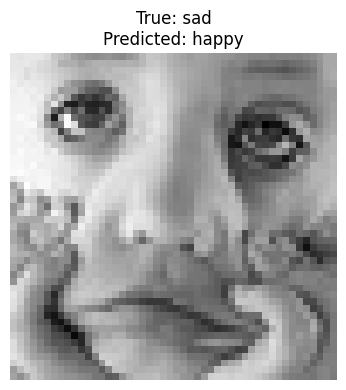

In [18]:
idx = random.randint(0, len(X_test) - 1)

img = X_test[idx]
true_lbl = y_test[idx]
pred_lbl = y_pred[idx]

plt.figure(figsize=(4, 4))
plt.imshow(img, cmap='gray')
plt.title(f"True: {categories[true_lbl]}\nPredicted: {categories[pred_lbl]}")
plt.axis('off')
plt.tight_layout()
plt.show()